<a href="https://colab.research.google.com/github/hotdog1029/deeplearning/blob/main/CIFAR_10_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%B4_MLP%2CCNN_%EB%AA%A8%EB%8D%B8_%EB%B9%84%EA%B5%90%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. 사용할 모듈 임포트하기
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets 

In [3]:
# 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('사용할 파이토치 버전: ', torch.__version__, 'Device: ',DEVICE)

사용할 파이토치 버전:  1.7.0+cu101 Device:  cpu


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
# 3. CIFAR10 데이터 다운로드 (train set, test set 분리하기)
train_dataset = datasets.CIFAR10(root = '../data/CIFAR10',
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = '../data/CIFAR10',
                                 train = False,
                                 download = True,
                                 transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ../data/CIFAR10/cifar-10-python.tar.gz


Extracting ../data/CIFAR10/cifar-10-python.tar.gz to ../data/CIFAR10
Files already downloaded and verified


In [6]:
# 4. 데이터 확인하기
for(x_train, y_train) in train_loader:
  print('x_trian: ',x_train.size(),x_train.type())  # 32개의 이미지 데이터가 1개의 미니배치를 구성하고 있고 가로 32개, 세로 32개의 픽셀로 구성돼 있고 채널이 3이므로 빨강,초록,파랑 색상으로 이뤄진, 다시말해 컬러로 이뤄진 이미지 데이터라는 것을 확인할 수 있다.
  print('y_trian: ',y_train.size(),y_train.type())  # 32개의 이미지 데이터 각각에 대해 label 값이 1개씩 존재하기 때문에 32개의 값을 갖고 있는 것을 확인할 수 있다.
  break

x_trian:  torch.Size([32, 3, 32, 32]) torch.FloatTensor
y_trian:  torch.Size([32]) torch.LongTensor


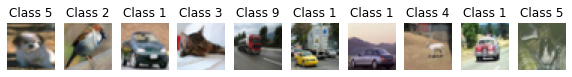

In [7]:
# 5. 데이터 확인하기 (1)
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(x_train[i],(1,2,0)))
  plt.title('Class '+ str(y_train[i].item()))

In [8]:
# 6. MLP 모델 설계하기
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(32 * 32 * 3, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self,x):
    x = x.view(-1,32 * 32 * 3)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x

In [9]:
# 7. optimizer , objective function 설정
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [10]:
# 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model,train_loader, optimizer, log_interval):
  model.train() 
  for batch_idx,(image,label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step() 
    
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:.0f}%(]\tTrain Loss: {:.6f}'.format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [15]:
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
# 10. MLP 학습을 실행하며 Train, Test Set의 Loss 및 정확도 확인
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n'.
        format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%(]	Train Loss: 1.232691
Train Epoch: 1 [6400/50000(13%(]	Train Loss: 1.590705
Train Epoch: 1 [12800/50000(26%(]	Train Loss: 1.764307
Train Epoch: 1 [19200/50000(38%(]	Train Loss: 1.893527
Train Epoch: 1 [25600/50000(51%(]	Train Loss: 1.699515
Train Epoch: 1 [32000/50000(64%(]	Train Loss: 1.304310
Train Epoch: 1 [38400/50000(77%(]	Train Loss: 1.699861
Train Epoch: 1 [44800/50000(90%(]	Train Loss: 1.511879

[EPOCH: 1], 	Test Loss: 0.0487, 	Test Accuracy: 43.34 %

Train Epoch: 2 [0/50000(0%(]	Train Loss: 1.552325
Train Epoch: 2 [6400/50000(13%(]	Train Loss: 1.542080
Train Epoch: 2 [12800/50000(26%(]	Train Loss: 1.626427
Train Epoch: 2 [19200/50000(38%(]	Train Loss: 1.590873
Train Epoch: 2 [25600/50000(51%(]	Train Loss: 1.389738
Train Epoch: 2 [32000/50000(64%(]	Train Loss: 1.414412
Train Epoch: 2 [38400/50000(77%(]	Train Loss: 1.398971
Train Epoch: 2 [44800/50000(90%(]	Train Loss: 1.585350

[EPOCH: 2], 	Test Loss: 0.0488, 	Test Accuracy: 43.63 %

Train Epoch: 3 [

사람의 손글씨 데이터인 흑백 이밎 데이터 MNIST 같은 경우, 기본적인 MLP 모델을 이용했을 때 검증 데이터셋 기준 정확도가 90% 수준으로 높은 수치의 성능을 갖는 인공지능 모델을 쉽게 구현할 수 있었습니다. 하지만 컬러 이미지 데이터인 CIFAR-10 과 같으 경우 검증 데이터셋 기준으로 정확도가 90% 수준으로 높은 수치의 성능을 갖는 인공지능 모델과 동일하게 설계해도 정확도가 48% 수준밖에 되지않는다.

그 이유는 흑백 데이터인 MNIST와 같은 경우 구조가 단순해 비교적 덜 민감하기도 하며 채널 수도 1이기 때문에 1차원으로 펼쳐 이용되는 것에 덜 민감하지만, CIFAR -10 데이터는 컬러 이미지이기 때문에 채널 수도 3이며 32 * 32 크기의 2차원 이미지가 3개 겹쳐 있어 모양을 형성하는 이미지를 32 * 32 * 3 1차원으로 펼쳐 놓으므로 이미지의 특징을 잃어버리는 것에 더욱 민감하다.

# 위에서 구현한 MLP를 CNN으로 변경해 구현하기

사용할 파이토치 버전:  1.7.0+cu101 Device:  cpu
Files already downloaded and verified
Files already downloaded and verified
x_trian:  torch.Size([32, 3, 32, 32]) torch.FloatTensor
y_trian:  torch.Size([32]) torch.LongTensor
Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
Train Epoch: 1 [0/50000(0%(]	Train Loss: 2.312462
Train Epoch: 1 [6400/50000(13%(]	Train Loss: 1.896890
Train Epoch: 1 [12800/50000(26%(]	Train Loss: 1.974348
Train Epoch: 1 [19200/50000(38%(]	Train Loss: 1.534730
Train Epoch: 1 [25600/50000(51%(]	Train Loss: 1.633149
Train Epoch: 1 [32000/50000(64%(]	Train Loss: 1.686095
Train Epoch: 1 [38400/50000(77%(]	Tr

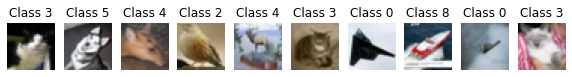

In [19]:
# 1. 사용할 모듈 임포트하기
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets 

# 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('사용할 파이토치 버전: ', torch.__version__, 'Device: ',DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

# 3. CIFAR10 데이터 다운로드 (train set, test set 분리하기)
train_dataset = datasets.CIFAR10(root = '../data/CIFAR10',
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = '../data/CIFAR10',
                                 train = False,
                                 download = True,
                                 transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

# 4. 데이터 확인하기
for(x_train, y_train) in train_loader:
  print('x_trian: ',x_train.size(),x_train.type())  # 32개의 이미지 데이터가 1개의 미니배치를 구성하고 있고 가로 32개, 세로 32개의 픽셀로 구성돼 있고 채널이 3이므로 빨강,초록,파랑 색상으로 이뤄진, 다시말해 컬러로 이뤄진 이미지 데이터라는 것을 확인할 수 있다.
  print('y_trian: ',y_train.size(),y_train.type())  # 32개의 이미지 데이터 각각에 대해 label 값이 1개씩 존재하기 때문에 32개의 값을 갖고 있는 것을 확인할 수 있다.
  break

# 5. 데이터 확인하기 (1)
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(x_train[i],(1,2,0)))
  plt.title('Class '+ str(y_train[i].item()))

# 6. Convolutional Neural Network(CNN) 모델 설계하기
class Net(nn.Module): # CNN도 MLP와 만찬가지로 nn.Module 클래스를 상속받는 클래스를 정의함
  def __init__(self): # CNN 클래스의 인스턴스를 생성했을 때 지니는 성질을 정의해주는 메서드
    super(Net, self).__init__() # nn.Module 내에 있는 메서드를 상속받아 이용
    self.conv1 = nn.Conv2d( # 2차원의 이미지 데이터를 nn.Conv2d 메서드를 이용해 합성곱 연산을 하는 필터를 정의한다.
        in_channels = 3, # 이미지에 직접 합성곱 연산을 진행하는 필터의 크기는 상관없지만, 채널 수를 이미지의 채널 수와 동일하게 맞춰야 한다. 
                         # 동일한 위치에 있으며 앞뒤로 존재하는 red,green,blue에 픽셀에 대해 동시에 합성곱 연산을 진해하기 위해서이다. 따라서 이미지의 채널 수와 동일하게 채널 수를 3으로 설정하였다.
        out_channels = 8, # 합성곱 연산을 진행하는 필터의 개수를 설정한다.
        kernel_size = 3, # 필터의 크기를 설정해주는 부분이다. , 3 * 3의 필터가 이미지 위를 돌아다니면서 겹치는 영역에 대해 9개의 픽샐 값과 필터내에 있는 9개의 파라미터 값을 합성곱 연산을 한다.
        padding = 1) # 세부 속성이 설정된 필터가 이미지 위를 돌아다닐 때 이미지의 구석 부분은 중앙 부분에 비해 상대적으로 덜 연산된다. 
                     # 필터가 돌아다니면서 겹치는 영역이 구석보다 중앙 부분이 당연히 자주 겹친다. 이를 방지하기 위해서 가장자리에 0을 채워 이미지 구석 부분과 중앙 부분이 합성곱연산 되는 횟수를 
                     # 동일하게 맞춰주는 Zero padding을 설정해주는 부분이다. 1로 설정하면 겉에 1층으로 0을 채워준다는 것을 의미한다.
    self.conv2 = nn.Conv2d(
        in_channels = 8,
        out_channels = 16,
        kernel_size = 3,
        padding = 1)
    self.pool = nn.MaxPool2d( # 합성곱을 통해 Feature Map이 생성됐을 때, Feature Map을 전부 이용하는 것이 아니라 부분적으로 이용한다.
        kernel_size = 2, # 생성된 Feature Map 내 2 * 2 크기의 필터가 돌아다니면서 가장 큰 Feature Map 값을 추출하는 것을 의미한다. 4개 값 중 1개의 값만 이용하고 나머지 3개 값은 버려진다.
        stride = 2) # stride는 2 * 2 크기의 필터가 MaxPooling하는 과정에서 Feature Map 위에서 움직이는 단위를 설정하는 부분이다. 이 예제에서는 2단위로 움직임
    self.fc1 = nn.Linear(8 * 8 * 16, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 10)

  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(-1, 8 * 8 * 16)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x

# 7. optimizer , objective function 설정
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

# 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model,train_loader, optimizer, log_interval):
  model.train() 
  for batch_idx,(image,label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step() 
    
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:.0f}%(]\tTrain Loss: {:.6f}'.format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))
      
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 10. MLP 학습을 실행하며 Train, Test Set의 Loss 및 정확도 확인
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n'.
        format(Epoch, test_loss, test_accuracy))

기존에 설계한 MLP 모델은 48% 수준에 그친 반면, 합성곱 연산을 추가한 CNN 모델은 성능이 약 63% 수준으로 향상된 것을 확인할 수있다.